# Part 3

### Transfer learning strategy: 

1. **Feature Extraction**:
    We utilize three pre-trained models: VGG19, ResNet50, and InceptionV3.
    The trainable parameters of these pre-trained models are frozen (`layer.trainable = False`). This means that the weights of these models will not be updated during training.
    These models are then used to extract features from the input data. Since the models are frozen, they act as feature extractors, and only the features they output will be used by the subsequent parts of the ensemble model.

2. **Pooling and Concatenation**:
    The extracted features from each pre-trained model are pooled using global average pooling, which reduces the dimensionality and extracts the most important information from the features.
    The pooled features from each of the three pre-trained models are then concatenated into a single feature vector. This concatenated feature vector combines the strengths and different perspectives of the three diverse architectures.

3. **Fully Connected Layer**:
    A fully connected (Dense) layer with 512 units and ReLU activation function is added on top of the concatenated features. This serves as a new classifier that is trainable and can learn from the combined features.

4. **Output Layer**:
    The output layer is another Dense layer with a number of units equal to the number of classes in the dataset (`num_classes`). It uses a softmax activation function to output probabilities for each class.

5. **Training and Evaluation**:
    The ensemble model, which includes the pre-trained, frozen base models and the trainable classifier, is then compiled and trained on the dataset using the Adam optimizer and categorical crossentropy loss. This trains only the weights of the new classifier layers because the base models are frozen. Finally, the trained ensemble model is evaluated on a test dataset to get the accuracy metric.

This strategy leverages the learned representations of different well-known architectures, which are powerful in extracting different kinds of features from images. By combining these features, the hope is to capture a richer representation that can lead to better performance than using any single pre-trained model alone.

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
# Assuming num_classes, image_size, train_generator, valid_generator, and test_generator are defined
num_classes = 100
image_size = 224
batch_size = 32

In [30]:
# Define image directories
train_dir = 'archive/train'
valid_dir = 'archive/valid'
test_dir = 'archive/test'

# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and testing data should not be augmented, only rescaled
test_datagen = ImageDataGenerator(rescale=1./255)

# Setup data loaders
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'  # Use 'binary' if you have two classes
)

valid_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'  # Use 'binary' if you have two classes
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',  # Use 'binary' if you have two classes
    shuffle=False  # Important for test set to not shuffle for evaluation
)


Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [14]:
# Load pre-trained models without the top layer
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
inceptionv3_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

In [15]:
# Freeze layers in the base models
for layer in vgg19_base.layers:
    layer.trainable = False

for layer in resnet50_base.layers:
    layer.trainable = False

for layer in inceptionv3_base.layers:
    layer.trainable = False

# Model inputs
input_tensor = Input(shape=(image_size, image_size, 3))

# Feature extraction
vgg19_features = vgg19_base(input_tensor)
resnet50_features = resnet50_base(input_tensor)
inceptionv3_features = inceptionv3_base(input_tensor)

# Pooling and concatenation
vgg19_pooled = GlobalAveragePooling2D()(vgg19_features)
resnet50_pooled = GlobalAveragePooling2D()(resnet50_features)
inceptionv3_pooled = GlobalAveragePooling2D()(inceptionv3_features)
concatenated_features = Concatenate()([vgg19_pooled, resnet50_pooled, inceptionv3_pooled])

# Fully connected layers
x = Dense(512, activation='relu')(concatenated_features)
predictions = Dense(num_classes, activation='softmax')(x)

# Final model
ensemble_model = Model(inputs=input_tensor, outputs=predictions)

# Compile the model
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
ensemble_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    epochs=10)

# Evaluate the model on the test dataset
accuracy = ensemble_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {accuracy[1]*100: }%')

Epoch 1/10
421/421 [==============================] - 6586s 16s/step - loss: 2.1471 - accuracy: 0.4716 - val_loss: 0.9336 - val_accuracy: 0.7354
Epoch 2/10
421/421 [==============================] - 7198s 17s/step - loss: 1.1615 - accuracy: 0.6700 - val_loss: 0.8540 - val_accuracy: 0.7396
Epoch 3/10
421/421 [==============================] - 3182s 8s/step - loss: 0.9904 - accuracy: 0.7081 - val_loss: 0.6042 - val_accuracy: 0.8271
Epoch 4/10
421/421 [==============================] - 3183s 8s/step - loss: 0.8789 - accuracy: 0.7444 - val_loss: 0.5321 - val_accuracy: 0.8292
Epoch 5/10
421/421 [==============================] - 3488s 8s/step - loss: 0.8115 - accuracy: 0.7589 - val_loss: 0.5586 - val_accuracy: 0.8438
Epoch 6/10
421/421 [==============================] - 5596s 13s/step - loss: 0.7829 - accuracy: 0.7686 - val_loss: 0.5782 - val_accuracy: 0.8271
Epoch 7/10
421/421 [==============================] - 6404s 15s/step - loss: 0.7363 - accuracy: 0.7797 - val_loss: 0.5434 - val_accur

Compared to the AlexNet pre-trained model from part 2:

- The ensemble model achieved a test accuracy of 88.96%, which is substantially higher than the best validation accuracy of AlexNet at 80%. This suggests that the ensemble model is more adept at generalizing and correctly classifying images from the test set.

- Training Stability: The ensemble model's accuracy improved consistently over epochs, whereas AlexNet's validation accuracy fluctuated and did not show a clear upward trend. This could imply that the ensemble model is more stable during training.

- Model Complexity: The ensemble approach utilizes more complex architectures, potentially capturing more nuanced features in the images, while AlexNet is a simpler and earlier generation model which might not capture as much detail.

- Computational Resources: Training the ensemble model would require more computational power and time due to the complexity of the three models compared to training a single AlexNet model. Even though the ensemble model requires more resources, it outperforms the AlexNet pre-trained model in accuracy and shows more stable training progress.

In [40]:
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt

16/16 [==============================] - 101s 6s/step


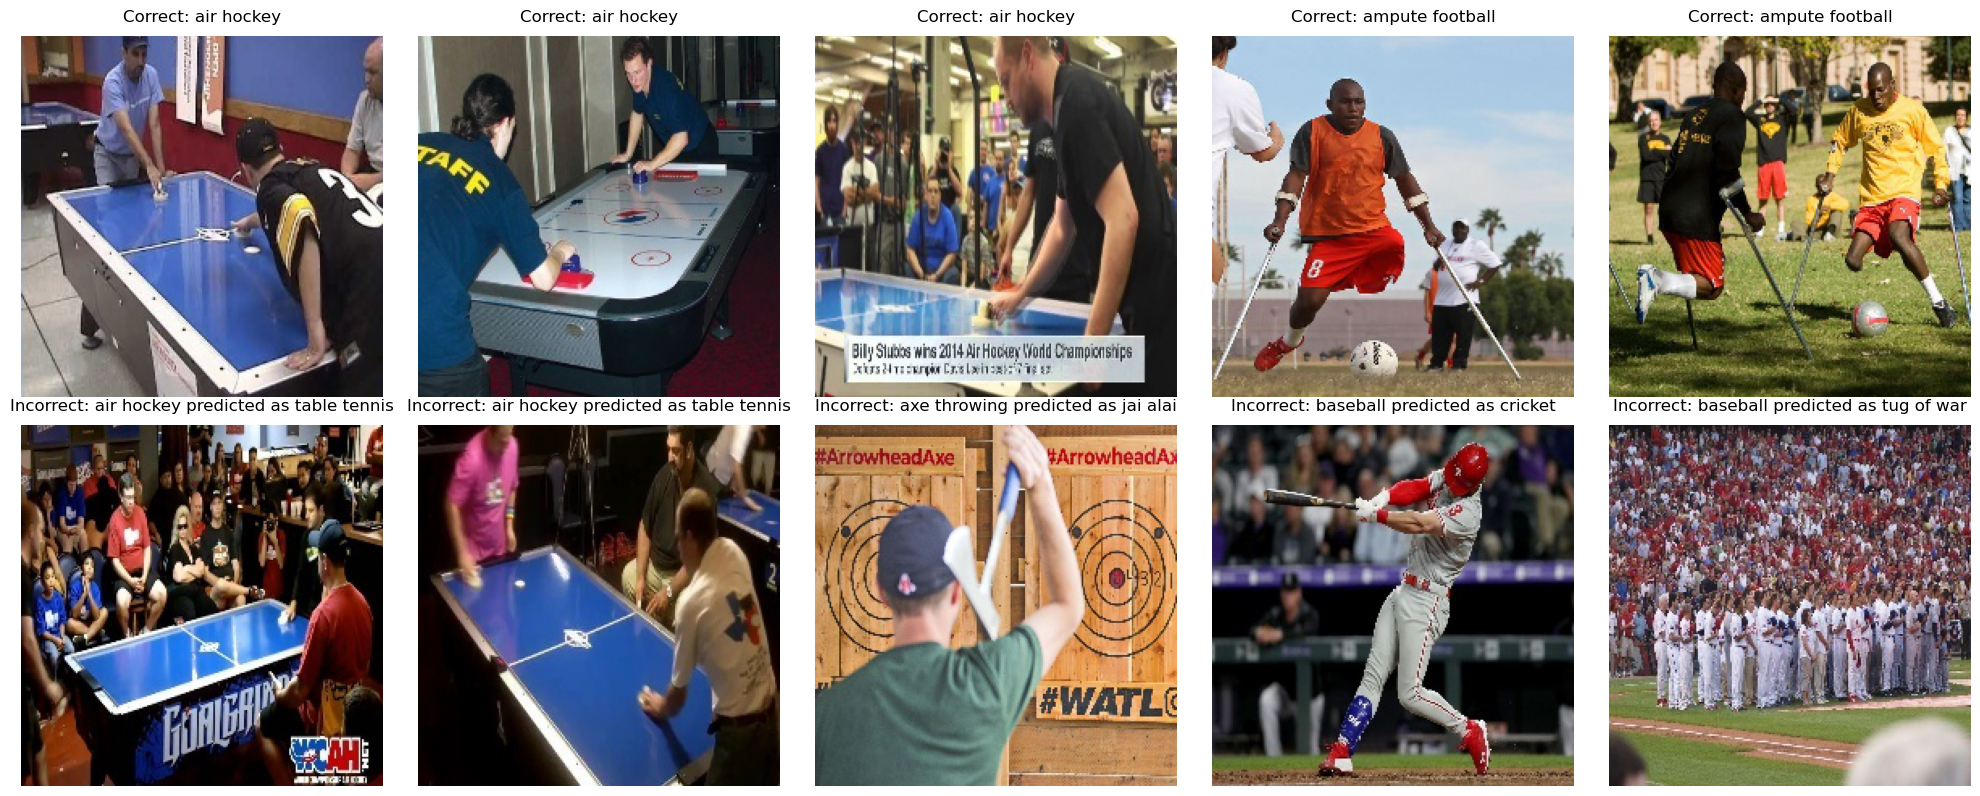

In [41]:
filenames = test_generator.filenames
nb_samples = len(filenames)
actual_labels = np.array([0] * nb_samples)
class_labels = list(test_generator.class_indices.keys())

for i,label in enumerate(test_generator.classes):
    actual_labels[i] = label

predictions = ensemble_model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

predicted_labels = np.argmax(predictions,axis = 1)

matches = predicted_labels == actual_labels

correct_indices = np.where(matches)[0]
incorrect_indices = np.where(~matches)[0]

selected_correct_indices = correct_indices[:5]
selected_incorrect_indices = incorrect_indices[:5]

fig,axs = plt.subplots(2,5,figsize=(20,8))
for i,idx in enumerate(selected_correct_indices):
    img = load_img(os.path.join(test_dir, filenames[idx]), target_size=(image_size,image_size))
    img = img_to_array(img).astype('uint8')
    axs[0,i].imshow(img)
    axs[0,i].set_title(f'Correct: {class_labels[actual_labels[idx]]}',pad=10)
    axs[0,i].axis('off')

for i,idx in enumerate(selected_incorrect_indices):
    img = load_img(os.path.join(test_dir, filenames[idx]), target_size=(image_size,image_size))
    img = img_to_array(img).astype('uint8')
    axs[1,i].imshow(img)
    axs[1,i].set_title(f'Incorrect: {class_labels[actual_labels[idx]]} predicted as {class_labels[predicted_labels[idx]]}',pad=10)
    axs[1,i].axis('off')

plt.tight_layout()
plt.show()
